In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from os.path import join, exists
import os
from ipywidgets import interact, SelectionSlider
from netCDF4 import Dataset
from scipy.linalg import cholesky
from scipy.stats import ttest_1samp, ttest_ind
from sklearn.decomposition import PCA
from deepsky.kriging import random_field_generator
from numba import jit

Generative Adversarial Networks (GANs) have demonstrated the ability to produce visually realistic synthetic examples from a set of data. Certain GAN configurations have been found to consistently produce good results, but there has not been justification for why these configurations work or why other configurations have issues. The purpose of this work is to evaluate GANs systematically on a synthetic spatial dataset where the properties of the dataset have been presecribed a priori. 

Distance between all points in lattice of random normal values Q: $D_{i,j}=\sqrt{(x_i-x_j)^2 + (y_i-y_j)^2}$.

Exponential kernel: $k=e^{-d/L}$

Correlation matrix: $C=k(D)$

Cholesky decomposition = $cho(C)=LL^*$

Correlated Random Field: $r=LQ$

De-correlated random field: $Q=L^{-1}r$


In [2]:
gan_path = "/d1/dgagne/random_gan_20170801/"
gan_param_combos = pd.read_csv(join(gan_path, "gan_param_combos.csv"), index_col="Index")

In [3]:
gan_param_combos.loc[1477:1500]

,activation,batch_size,beta_one,data_width,dropout_alpha,filter_width,generator_input_size,learning_rate,length_scale,min_conv_filters,min_data_width,seed,train_size
Index,,,,,,,,,,,,,
1477,leaky,256,0.5,32,0.0,5,128,0.0001,full;3,32,4,14268489,131072
1478,leaky,256,0.5,32,0.0,5,128,0.0001,full;3,64,4,14268489,16384
1479,leaky,256,0.5,32,0.0,5,128,0.0001,full;3,64,4,14268489,131072
1480,leaky,256,0.5,32,0.0,5,128,0.0001,full;3,128,4,14268489,16384
1481,leaky,256,0.5,32,0.0,5,128,0.0001,full;3,128,4,14268489,131072
1482,leaky,256,0.5,32,0.0,5,128,0.0001,full;8,32,4,14268489,16384
1483,leaky,256,0.5,32,0.0,5,128,0.0001,full;8,32,4,14268489,131072
1484,leaky,256,0.5,32,0.0,5,128,0.0001,full;8,64,4,14268489,16384
1485,leaky,256,0.5,32,0.0,5,128,0.0001,full;8,64,4,14268489,131072


activation                relu
dropout_alpha                0
filter_width                 3
generator_input_size       128
length_scale            full;3
min_conv_filters           128
Name: 77, dtype: object


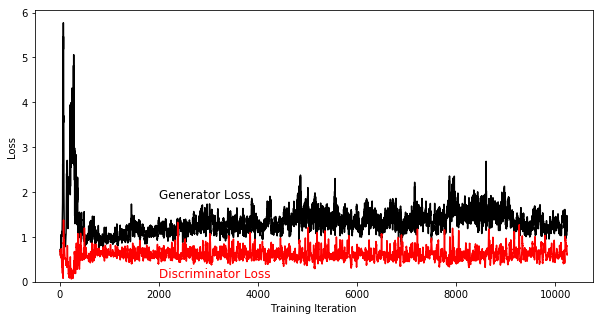

In [17]:
def plot_loss_history(index):
    i = int(index)
    hist_file = join(gan_path, "gan_loss_history_{0:04d}.csv".format(index))
    plt.figure(figsize=(10, 5))
    print(gan_param_combos.loc[i, ["activation", 
                                   "dropout_alpha", 
                                   "filter_width", 
                                   "generator_input_size", 
                                   "length_scale",
                                   "min_conv_filters",
                                  ]])
    if exists(hist_file):
        loss_history = pd.read_csv(hist_file)
        plt.plot(loss_history["Gen Loss"], 'k-')
        plt.plot(loss_history["Disc Loss"], 'r-')
        plt.xlabel("Training Iteration")
        plt.ylabel("Loss")
        plt.text(2000, loss_history["Disc Loss"][2000] - 0.5, "Discriminator Loss", fontsize=12, color="red")
        plt.text(2000, loss_history["Gen Loss"][2000] + 0.5, "Generator Loss", fontsize=12, color="k")
        plt.ylim(0)
        #plt.plot(loss_history["Enc Loss"], 'b-')
    else:
        plt.text(0,0, "No Data")
    plt.show()
gan_loss_files = pd.Series(glob(join(gan_path, "gan_loss_history_*.csv")))
gan_loss_indices = gan_loss_files.str[-8:-4].values.astype(int)
valid_loss_indices = gan_param_combos.loc[np.in1d(gan_param_combos.index,gan_loss_indices) & 
                                          (gan_param_combos["train_size"] > 100000)].index.tolist()
interact(plot_loss_history, index=SelectionSlider(options=valid_loss_indices))

activation                  relu
batch_size                   256
beta_one                     0.5
data_width                    32
dropout_alpha                  0
filter_width                   3
generator_input_size          16
learning_rate             0.0001
length_scale              full;3
min_conv_filters              32
min_data_width                 4
seed                    14268489
train_size                131072
Name: 1, dtype: object


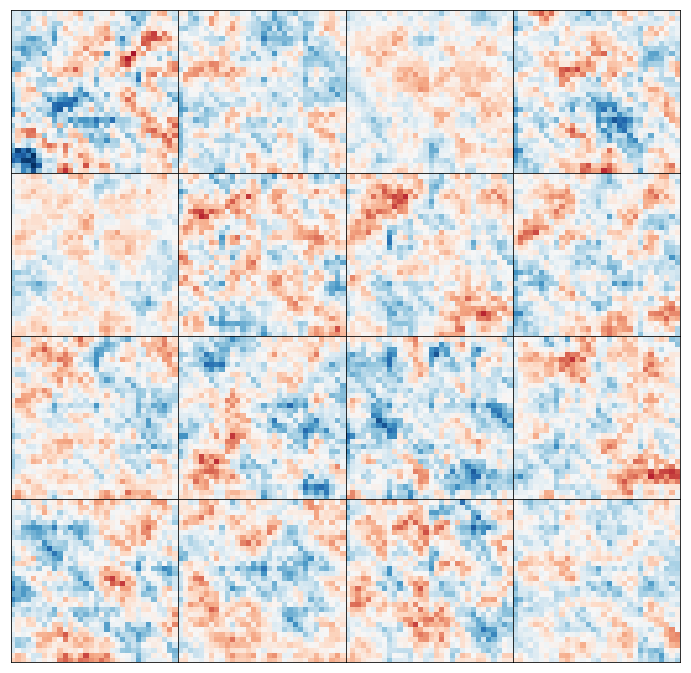

In [18]:
gan_index = 3
epoch = 10
def plot_patches(gan_index, epoch):
    print(gan_param_combos.loc[gan_index])
    num_patch_rows = 4
    gan_patch_set = Dataset(join(gan_path, "gan_gen_patches_{0:04d}_epoch_{1:04d}.nc").format(gan_index, epoch))
    gan_patches = gan_patch_set.variables["gen_patch"][0:num_patch_rows ** 2, :, :, 0]
    gan_patch_set.close()
    fig, axes = plt.subplots(num_patch_rows, num_patch_rows, figsize=(12, 12))
    plt.subplots_adjust(wspace=0, hspace=0)
    a = 0
    for (r, c), ax in np.ndenumerate(axes):
        ax.pcolormesh(gan_patches[a], vmin=-4, vmax=4, cmap="RdBu_r")
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        a += 1
    plt.show()
interact(plot_patches, gan_index=SelectionSlider(options=valid_loss_indices), 
         epoch=SelectionSlider(options=[1,2,3,4,5, 8, 10]))

In [3]:
def distance_matrix(x, y):
    x_flat = x.reshape(-1, 1).astype(np.float64)
    y_flat = y.reshape(-1, 1).astype(np.float64)
    return np.sqrt((x_flat - x_flat.T) ** 2 + (y_flat - y_flat.T) ** 2)

@jit
def exp_kernel(distance, length_scale):
    return np.exp(-distance / length_scale)

x_f = np.arange(32)
y_f = np.arange(32)
x_g, y_g = np.meshgrid(x_f, y_f)
distances = distance_matrix(x_g, y_g)

In [25]:
sub_distances = np.array(distances, copy=True)
sub_distances[np.triu_indices(sub_distances.shape[0])] = 999999

@jit(nopython=True)
def spatial_covariance(distances, z, eval_distances, tolerance):
    covariances = np.zeros(eval_distances.size)
    z_flat = z.ravel()
    for d, eval_distance in enumerate(eval_distances):
        points_a, points_b = np.where(np.abs(sub_distances - eval_distance) <= tolerance)
        covariances[d] = np.sum((z_flat[points_a] - z_flat[points_a].mean()) *
                                (z_flat[points_b] - z_flat[points_b].mean())) / (float(points_a.size) - 1.0)
        covariances[d] /= z_flat[points_a].std() * z_flat[points_b].std()
    return covariances



In [37]:
corr = exp_kernel(distances, 8)
cho = cholesky(np.linalg.inv(corr), lower=True)
cho_inv = np.linalg.inv(cho)

In [23]:
?cholesky

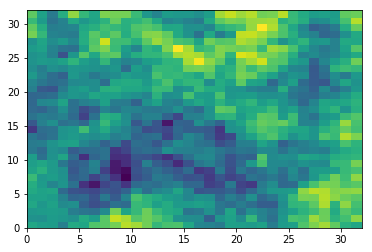

In [41]:
plt.pcolormesh(np.matmul(cho_inv.T, np.random.normal(size=(1024, 1))).reshape(32, 32))

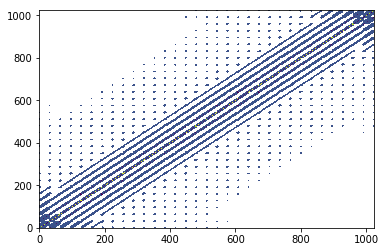

In [50]:
inv_corr = np.linalg.inv(corr)
plt.pcolormesh(np.ma.array(inv_corr, mask=np.abs(inv_corr) < 1e-3))

In [69]:
cho_2 = np.linalg.cholesky(corr)
np.linalg.inv(cho)

array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -1.02720414e+00,   1.43357886e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,  -1.02720414e+00,   1.43357886e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  1.06235193e-11,   3.92620662e-12,   6.09502888e-12, ...,
          1.71066812e+00,   0.00000000e+00,   0.00000000e+00],
       [  9.00140265e-12,   3.57176844e-12,   5.47371084e-12, ...,
         -7.48829857e-01,   1.70576468e+00,   0.00000000e+00],
       [  1.01749011e-11,   4.62519959e-12,   6.95283969e-12, ...,
          6.36912086e-03,  -7.57332942e-01,   1.65365555e+00]])

In [13]:
gan_index = 1477
epoch = 10
gan_patch_set = Dataset(join(gan_path, "gan_gen_patches_{0:04d}_epoch_{1:04d}.nc").format(gan_index, epoch))
gan_patches = np.array(gan_patch_set.variables["gen_patch"][:, :, :, 0])
gan_patch_set.close()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 486,
 487,
 488,
 489,
 490,
 491,
 492,
 493,
 494,
 495,
 496,
 497,
 498,
 499,
 500,
 501,
 502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 510,
 511,
 512,
 513,
 514,
 515,
 516,
 517,
 518

In [14]:
rand_patches = np.zeros(gan_patches.shape)
for p, patch in enumerate(gan_patches):
    rand_patches[p] = np.matmul(cho_inv, patch.reshape(patch.size, 1)).reshape(patch.shape)

In [15]:
eval_distances = np.arange(1, 9)
covs = np.zeros((gan_patches.shape[0], eval_distances.size))
for p, patch in enumerate(gan_patches):
    covs[p] = spatial_covariance(distances, patch, eval_distances, 0.1)


In [17]:
eval_distances = np.arange(1, 9)
rand_covs = np.zeros((gan_patches.shape[0], eval_distances.size))
for p, patch in enumerate(rand_patches):
    rand_covs[p] = spatial_covariance(distances, patch, eval_distances, 0.1)

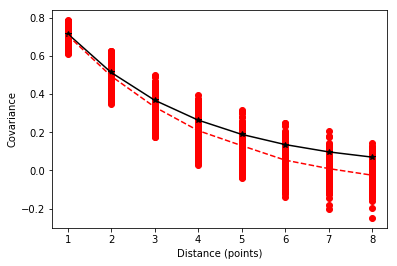

In [18]:
for cov in covs:
    plt.plot(eval_distances, cov, 'ro')
plt.plot(eval_distances, exp_kernel(eval_distances, 3), 'k*-')
plt.plot(eval_distances, covs.mean(axis=0), 'r--')
plt.xlabel("Distance (points)")
plt.ylabel("Covariance")

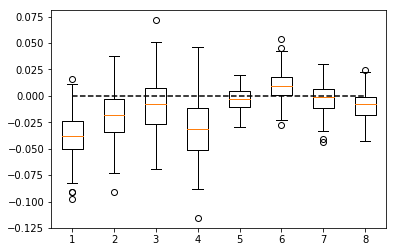

In [19]:
plt.boxplot(rand_covs, positions=eval_distances)
plt.plot(eval_distances, np.zeros(eval_distances.size), 'k--')
#plt.plot(eval_distances, exp_kernel(eval_distances, 3), 'k*-')

In [23]:
full_3_combos = gan_param_combos.loc[(gan_param_combos["train_size"] > 100000) & (gan_param_combos["length_scale"] == "full;3")]
epoch = 10
eval_distances = np.arange(1, 7)
gan_mean_cols = ["cov_mean_{0:02d}".format(x) for x in eval_distances]
gan_sd_cols = ["cov_sd_{0:02d}".format(x) for x in eval_distances]
gan_t_cols = ["cov_t_{0:02d}".format(x) for x in eval_distances]
gan_stat_cols = gan_mean_cols + gan_sd_cols + gan_t_cols + ["mean_tscore"]
gan_stats = pd.DataFrame(np.zeros((full_3_combos.shape[0], len(gan_stat_cols))), 
                                   index=full_3_combos.index, columns=gan_stat_cols)
rand_covs = np.zeros((256, eval_distances.size))
corr = exp_kernel(distances, 3)
cho = cholesky(corr, lower=True)
cho_inv = np.linalg.inv(cho)
rand_covs = np.zeros((256, eval_distances.size))
random_gen = random_field_generator(x_g, y_g, [3])
random_fields = np.stack([next(random_gen) for x in range(256)], axis=0)[:, :, :, 0]
random_noise = np.stack([np.matmul(cho_inv, 
                                   random_field.reshape(random_field.size, 1)).reshape(random_fields.shape[1:]) for random_field in random_fields], axis=0)
for index in full_3_combos.index:
    print(index)
    gan_patch_file = join(gan_path, "gan_gen_patches_{0:04d}_epoch_{1:04d}.nc".format(index, epoch))
    if exists(gan_patch_file):
        gan_patch_ds = Dataset(gan_patch_file)
        gan_patches = np.array(gan_patch_ds.variables["gen_patch"][:, :, :, 0])
        gan_patch_ds.close()
        for p, patch in enumerate(gan_patches):
            rand_patch = np.matmul(cho_inv, patch.reshape(patch.size, 1)).reshape(patch.shape)
            rand_covs[p] = spatial_covariance(distances, rand_patch, eval_distances, 0.1)
        gan_stats.loc[index, gan_mean_cols] = rand_covs.mean(axis=0)
        gan_stats.loc[index, gan_sd_cols] = rand_covs.std(axis=0)
        gan_stats.loc[index, gan_t_cols] = gan_stats.loc[index, gan_mean_cols].values / (gan_stats.loc[index, gan_sd_cols].values / np.sqrt(255))
        gan_stats.loc[index, "mean_tscore"] = np.abs(gan_stats.loc[index, gan_t_cols]).mean()
        #print(gan_stats.loc[index])

1
3
5
37
39
41
73
75
77
109
111
113
145
147
149


KeyboardInterrupt: 

In [53]:
full_8_combos = gan_param_combos.loc[(gan_param_combos["train_size"] > 100000) & (gan_param_combos["length_scale"] == "full;8")]
epoch = 10
eval_distances = np.arange(1, 12)
gan_mean_cols = ["cov_mean_{0:02d}".format(x) for x in eval_distances]
gan_sd_cols = ["cov_sd_{0:02d}".format(x) for x in eval_distances]
gan_t_cols = ["cov_t_{0:02d}".format(x) for x in eval_distances]
gan_stat_cols = gan_mean_cols + gan_sd_cols + gan_t_cols + ["mean_tscore"]
gan_stats_8 = pd.DataFrame(np.zeros((full_8_combos.shape[0], len(gan_stat_cols))), 
                                   index=full_8_combos.index, columns=gan_stat_cols)
rand_covs = np.zeros((256, eval_distances.size))
corr = exp_kernel(distances, 8)
cho = cholesky(corr, lower=True)
cho_inv = np.linalg.inv(cho)
rand_covs = np.zeros((256, eval_distances.size))
for index in full_8_combos.index:
    #print(index)
    gan_patch_file = join(gan_path, "gan_gen_patches_{0:04d}_epoch_{1:04d}.nc".format(index, epoch))
    if exists(gan_patch_file):
        gan_patch_ds = Dataset(gan_patch_file)
        gan_patches = np.array(gan_patch_set.variables["gen_patch"][:, :, :, 0])
        gan_patch_ds.close()
        for p, patch in enumerate(gan_patches):
            rand_patch = np.matmul(cho_inv, patch.reshape(patch.size, 1)).reshape(patch.shape)
            rand_covs[p] = spatial_covariance(distances, rand_patch, eval_distances, 0.1)
        gan_stats_8.loc[index, gan_mean_cols] = rand_covs.mean(axis=0)
        gan_stats_8.loc[index, gan_sd_cols] = rand_covs.std(axis=0)
        gan_stats_8.loc[index, gan_t_cols] = gan_stats_8.loc[index, gan_mean_cols].values / (gan_stats_8.loc[index, gan_sd_cols].values / np.sqrt(255))
        gan_stats_8.loc[index, "mean_tscore"] = np.abs(gan_stats_8.loc[index, gan_t_cols]).mean()
        print(index, gan_stats_8.loc[index, "mean_tscore"])

7 42.6580390954
9 38.0265973955
11 48.965432449
43 17.9671956726
45 66.2402198612
47 45.2525851462
79 21.244884429
81 39.6988619645
83 65.0257081484
115 48.8522889495
117 15.7315451959
119 16.8946346184
151 22.8901419471
153 35.2535345307
155 33.0760681037
187 25.2510745627
189 28.3691390441
191 14.2761869927
223 62.5439063854
225 70.7470432597
227 47.1191009702
259 23.1588687321
261 86.6963700758
263 28.1562100108
295 49.1664393121
297 45.9426490674
299 52.9327368566
331 45.3291741736
333 25.8304098727
335 15.8528830405
367 42.9046512679
369 41.3567188634
371 22.7615742325
403 36.330473527
405 20.5936771559
407 14.5722404837
439 65.0371250412
441 64.680665292
443 47.0757911011
475 31.5549032687
477 100.374162588
479 49.6057280891
511 36.0381472264
513 63.63195934
515 109.132433756
547 26.9784884896
549 33.2520925861
551 11.1553222126
583 61.5373925349
585 26.4329538797
587 8.6229802289
619 34.4529066493
621 15.4007775884
623 12.0321730955
655 33.283261333
657 19.2180914764
659 28.9913

In [24]:
full_3_combos

,activation,batch_size,beta_one,data_width,dropout_alpha,filter_width,generator_input_size,learning_rate,length_scale,min_conv_filters,min_data_width,seed,train_size
Index,,,,,,,,,,,,,
1,relu,256,0.5,32,0.00,3,16,0.0001,full;3,32,4,14268489,131072
3,relu,256,0.5,32,0.00,3,16,0.0001,full;3,64,4,14268489,131072
5,relu,256,0.5,32,0.00,3,16,0.0001,full;3,128,4,14268489,131072
37,relu,256,0.5,32,0.00,3,32,0.0001,full;3,32,4,14268489,131072
39,relu,256,0.5,32,0.00,3,32,0.0001,full;3,64,4,14268489,131072
41,relu,256,0.5,32,0.00,3,32,0.0001,full;3,128,4,14268489,131072
73,relu,256,0.5,32,0.00,3,128,0.0001,full;3,32,4,14268489,131072
75,relu,256,0.5,32,0.00,3,128,0.0001,full;3,64,4,14268489,131072
77,relu,256,0.5,32,0.00,3,128,0.0001,full;3,128,4,14268489,131072


In [56]:
param_stats = pd.merge(gan_stats, gan_param_combos, left_index=True, right_index=True)
param_stats_8 = pd.merge(gan_stats_8, gan_param_combos, left_index=True, right_index=True)

In [37]:
param_stats.columns

Index(['cov_mean_01', 'cov_mean_02', 'cov_mean_03', 'cov_mean_04',
       'cov_mean_05', 'cov_mean_06', 'cov_sd_01', 'cov_sd_02', 'cov_sd_03',
       'cov_sd_04', 'cov_sd_05', 'cov_sd_06', 'cov_t_01', 'cov_t_02',
       'cov_t_03', 'cov_t_04', 'cov_t_05', 'cov_t_06', 'mean_tscore',
       'activation', 'batch_size', 'beta_one', 'data_width', 'dropout_alpha',
       'filter_width', 'generator_input_size', 'learning_rate', 'length_scale',
       'min_conv_filters', 'min_data_width', 'seed', 'train_size'],
      dtype='object')

In [60]:
param_stats_8.loc[1415]

cov_mean_01            -0.00250271
cov_mean_02              0.0159103
cov_mean_03            -0.00144863
cov_mean_04             0.00716876
cov_mean_05            -0.00753921
cov_mean_06            -0.00604182
cov_mean_07            -0.00804353
cov_mean_08              0.0115759
cov_mean_09              0.0154107
cov_mean_10             -0.0128688
cov_mean_11            -0.00398817
cov_sd_01                0.0218608
cov_sd_02                 0.038481
cov_sd_03                0.0238948
cov_sd_04                0.0810983
cov_sd_05                0.0114541
cov_sd_06                0.0186043
cov_sd_07                0.0129978
cov_sd_08                 0.017508
cov_sd_09                0.0243494
cov_sd_10                0.0207459
cov_sd_11                0.0148076
cov_t_01                  -1.82816
cov_t_02                   6.60241
cov_t_03                 -0.968106
cov_t_04                   1.41157
cov_t_05                  -10.5108
cov_t_06                   -5.1859
cov_t_07            

In [50]:
param_stats_8.groupby(["activation", "generator_input_size",  "min_conv_filters"])["mean_tscore"].mean()

activation  generator_input_size  min_conv_filters
leaky       16                    32                  31.496972
                                  64                  18.442859
                                  128                 14.184098
            32                    32                  22.872830
                                  64                  16.387755
                                  128                 15.389986
            128                   32                  23.549688
                                  64                  17.892711
                                  128                 13.070307
relu        16                    32                  40.266197
                                  64                  34.004656
                                  128                 26.253261
            32                    32                  31.162052
                                  64                  51.091992
                                  128                

In [42]:
param_stats.groupby(["activation", "generator_input_size",  "min_conv_filters"])["mean_tscore"].mean()

activation  generator_input_size  min_conv_filters
leaky       16                    32                  22.060870
                                  64                   9.046031
                                  128                 10.478683
            32                    32                  24.810268
                                  64                   7.807782
                                  128                 11.525811
            128                   32                  28.829847
                                  64                   9.757904
                                  128                 10.124940
relu        16                    32                  43.845874
                                  64                  53.998871
                                  128                 37.177067
            32                    32                  43.251293
                                  64                  67.791930
                                  128                

In [33]:
rand_covs.mean(axis=0) / (rand_covs.std(axis=0) / np.sqrt(256))

array([-39.0067822 ,  17.84221841, -21.81347203,  76.18985832,
       -15.86412843, -11.76313301, -17.21443753,  35.21271735,
         4.25939047,  -8.31191961, -26.27969042,   8.29072105,
         0.61216273,  -3.64385412,  -7.86679877,  18.42345865])

In [34]:
rand_covs.mean(axis=0)

array([-0.065216  ,  0.04923398, -0.03695568,  0.24437319, -0.01359776,
       -0.01294718, -0.02038573,  0.04384881,  0.00615182, -0.01006078,
       -0.02731359,  0.00564907,  0.00064464, -0.00341985, -0.00746097,
        0.04176786])

In [152]:
np.sqrt(np.mean(ttest_1samp(rand_covs, 0, axis=0).statistic ** 2))

13.623668933971674

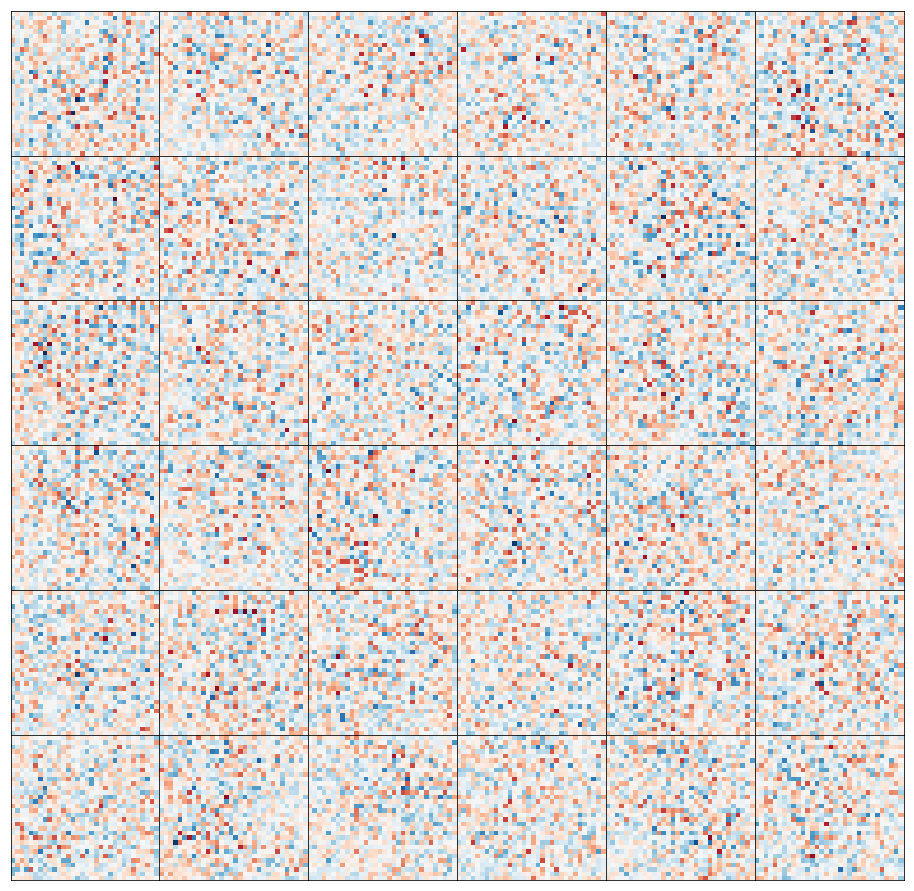

In [116]:
fig, axes = plt.subplots(num_patch_rows, num_patch_rows, figsize=(16, 16))
plt.subplots_adjust(wspace=0, hspace=0)
for (r, c), ax in np.ndenumerate(axes):
    ax.pcolormesh(rand_patches[a], vmin=-4, vmax=4, cmap="RdBu_r")
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    a += 1


In [128]:
e = np.random.normal(size=(1024, 1))
f = np.random.normal(size=(1024, 1))
corr_3 = exp_kernel(distances, 3)
corr_8 = exp_kernel(distances, 8)
cho_3 = cholesky(corr_3, lower=True)
cho_8 = cholesky(corr_8, lower=True)
out = np.matmul(cho_3, e) + np.matmul(cho_8, f)
e_again = np.matmul(np.linalg.inv(cho_3), out).reshape(32, 32)

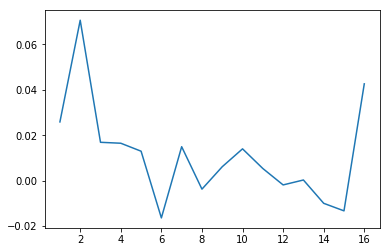

In [176]:
plt.plot(eval_distances, spatial_covariance(distances, e_again, eval_distances, 0.1))

In [163]:
rand_patches = np.zeros(gan_patches.shape)
for p, patch in enumerate(gan_patches.data):
    rand_patches[p] = np.matmul(cho_inv, patch.reshape(patch.size, 1)).reshape(patch.shape)

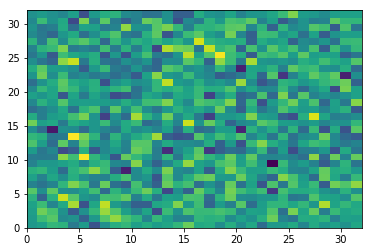

In [85]:
pc = PCA(n_components=256)
pc.fit(gan_patches.reshape(256, 32 * 32))

PCA(copy=True, iterated_power='auto', n_components=256, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

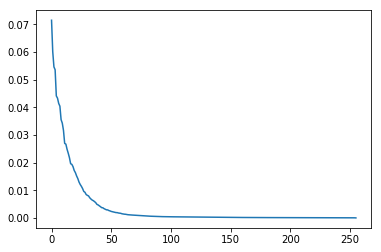

In [103]:
plt.plot(pc.explained_variance_ratio_)

In [94]:
eigout = np.linalg.eig(corr)

(0, 128)

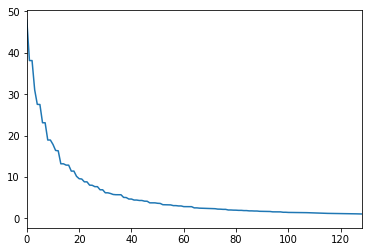

In [104]:
plt.plot(np.sort(eigout[0])[::-1])
plt.xlim(0, 128)

In [122]:
from deepsky.kriging import random_field_generator

In [123]:
gen = random_field_generator(x_g, y_g, np.array([3]))

In [148]:
random_fields = np.stack([next(gen) for x in range(256)], axis=0)

In [149]:
cho_inv_3 = np.linalg.inv(cho_3)
noise_covs = np.zeros((256, eval_distances.size))
for r, random_field in enumerate(random_fields):
    noise_field = np.matmul(cho_inv_3, random_field[:, :, 0].reshape(1024, 1))
    noise_covs[r] = spatial_covariance(distances, noise_field, eval_distances, 0.1)
    

In [150]:
noise_covs.std(axis=0)

array([ 0.02054843,  0.02272894,  0.02513495,  0.0254657 ,  0.01041655,
        0.01437884])

In [152]:
noise_covs.mean(axis=0)

array([-0.00255267, -0.00218324, -0.00317764,  0.00275801, -0.00147864,
       -0.00113355])

In [153]:
ttest_ind(rand_covs, noise_covs, equal_var=False)

Ttest_indResult(statistic=array([ -8.05092816,  33.46475569,  -7.22116618,  17.3566552 ,
       -22.9570681 ,   5.56908625]), pvalue=array([  5.86287860e-015,   2.03140336e-130,   1.88685073e-012,
         4.02716521e-051,   4.17010300e-080,   4.15643488e-008]))

In [145]:
ttest_1samp(rand_covs, 0)

Ttest_1sampResult(statistic=array([-12.95852276,  44.09539693, -12.42970937,  21.20795537,
       -32.17485343,   6.45167646]), pvalue=array([  7.61738210e-030,   2.59875591e-121,   4.77504214e-028,
         3.17736928e-058,   9.32901043e-092,   5.52611530e-010]))